In [1]:
import numpy as np
import pandas as pd
import queue
import matplotlib.pyplot as plt

import sys
backtest_dir = 'C://backtest/backtest/'
if backtest_dir not in sys.path:
    sys.path.insert(0, backtest_dir)
    
from Backtest import *
from BayesianOptimization import *
from MACDStrategy import MACDStrategy
from Backtest.open_json_gz_files import open_json_gz_files
from Backtest.generate_bars import generate_bars

In [2]:
def run_backtest(config, trading_data, ohlc_data, short_window, delta_window):
    short_window = int(short_window)
    long_window = short_window + int(delta_window)
    config['title'] = "MACDStrategy" + "_" + str(short_window) + "_" + str(long_window)
    print("---------------------------------")
    print(config['title'])
    print("---------------------------------")
    
    events_queue = queue.Queue()

    data_handler = OHLCDataHandler(
        config, events_queue,
        trading_data = trading_data, ohlc_data = ohlc_data
    )
    strategy = MACDStrategy(config, events_queue, data_handler,
                            short_window=short_window, long_window=long_window)

    backtest = Backtest(config, events_queue, strategy,
                        data_handler= data_handler)

    results = backtest.start_trading()
    
    # dict_ans = {
    #     "short_window": [short_window],
    #     "long_window": [long_window],
    #     "Sharpe Ratio": [results['sharpe']],
    #     "Total Returns": [(results['cum_returns'][-1] - 1)],
    #     "Max Drawdown": [(results["max_drawdown"] * 100.0)],
    #     "Max Drawdown Duration": [(results['max_drawdown_duration'])],
    #     "Trades": [results['trade_info']['trading_num']],
    #     "Trade Winning": [results['trade_info']['win_pct']],
    #     "Average Trade": [results['trade_info']['avg_trd_pct']],
    #     "Average Win": [results['trade_info']['avg_win_pct']],
    #     "Average Loss": [results['trade_info']['avg_loss_pct']],
    #     "Best Trade": [results['trade_info']['max_win_pct']],
    #     "Worst Trade": [results['trade_info']['max_loss_pct']],
    #     "Worst Trade Date": [results['trade_info']['max_loss_dt']],
    #     "Avg Days in Trade": [results['trade_info']['avg_dit']]
    # }
    # return pd.DataFrame(dict_ans)
    return (results['cum_returns'][-1] - 1)

## Setting

In [3]:
config = {
    "csv_dir": "C:/backtest/Binance",
    "out_dir": "C:/backtest/results/MACDStrategy",
    "title": "MACDStrategy",
    "is_plot": False,
    "save_plot": False,
    "save_tradelog": False,
    "start_date": pd.Timestamp("2017-07-01T00:0:00", freq = "60" + "T"),    # str(freq) + "T"
    "end_date": pd.Timestamp("2018-04-01T00:00:00", freq = "60" + "T"),
    "equity": 1.0,
    "freq": 60,      # min
    "commission_ratio": 0.001,
    "suggested_quantity": None,     # None or a value
    "max_quantity": None,           # None or a value, Maximum purchase quantity
    "min_quantity": None,           # None or a value, Minimum purchase quantity
    "min_handheld_cash": None,      # None or a value, Minimum handheld funds
    "exchange": "Binance",
    "tickers": ['BTCUSDT']
}

In [4]:
# trading_data = {}
# for ticker in config['tickers']:
#     # trading_data[ticker] = open_gz_files(config['csv_dir'], ticker)
#     trading_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker + '.h5', key=ticker)

ohlc_data = {}
for ticker in config['tickers']:
    # ohlc_data[ticker] = generate_bars(trading_data, ticker, config['freq'])
    ohlc_data[ticker] = pd.read_hdf(config['csv_dir'] + '\\' + ticker +'_OHLC_60min.h5', key=ticker)

trading_data = None

In [5]:
gp_params = {"alpha": 1e-5}

## Acquisition Function "Upper Confidence Bound"

* Prefer exploitation (kappa=1.0)

* Prefer exploration (kappa=10)


## Acquisition Function "Expected Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)

In [6]:
BO = BayesianOptimization(
    run_backtest,
    {'short_window': (1, 120),
    'delta_window': (1, 120)},
    is_int = [1, 1], 
    invariant = {
        'config': config,
        'trading_data': trading_data,
        'ohlc_data': ohlc_data
    },
    random_state = 1
)
# BO.explore({
#     'short_window': np.arange(1, 120, 20),
#     'delta_window': np.arange(1, 120, 20)
#     },
#     eager=True)
BO.maximize(init_points=20, n_iter=40, acq="ei", xi=0.01, **gp_params)

Initialization
---------------------------------------------------------------
 Step |   Time |      Value |   delta_window |   short_window | 
---------------------------------
MACDStrategy_38_123
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.8385685862
Max Drawdown: 38.5045571794
Max Drawdown Duration: 2736
Total Returns: 1.0633616852
---------------------------------
Trades: 17
Trade Winning: 59%
Average Trade: 5.26%
Average Win: 12.10%
Average Loss: -4.50%
Best Trade: 31.19%
Worst Trade: -16.10%
Worst Trade Date: 2 days 04:00:00
Avg Days in Trade: 5 days 00:17:39
---------------------------------
    1 | 00m05s |    1.06336 | 85.000000 | 38.000000 | 
---------------------------------
MACDStrategy_108_120
-----

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.0116618187
Max Drawdown: 49.2225451070
Max Drawdown Duration: 2736
Total Returns: 0.4436805922
---------------------------------
Trades: 52
Trade Winning: 25%
Average Trade: 1.24%
Average Win: 12.70%
Average Loss: -2.58%
Best Trade: 33.42%
Worst Trade: -6.29%
Worst Trade Date: 0 days 05:00:00
Avg Days in Trade: 1 days 15:31:09
---------------------------------
   11 | 00m05s |    0.44368 | 106.000000 | 2.000000 | 
---------------------------------
MACDStrategy_77_191
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.1982432361
Max Drawdown: 54.0682801047
Max Drawdown Duration: 2510
Total Returns: 0.5547076615
-------

---------------------------------
MACDStrategy_22_31
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.3767461358
Max Drawdown: 31.1247268645
Max Drawdown Duration: 1548
Total Returns: 1.8106493523
---------------------------------
Trades: 64
Trade Winning: 55%
Average Trade: 2.14%
Average Win: 6.87%
Average Loss: -3.56%
Best Trade: 35.51%
Worst Trade: -16.60%
Worst Trade Date: 0 days 20:00:00
Avg Days in Trade: 1 days 06:13:08
---------------------------------
   22 | 00m03s |    1.81065 | 9.000000 | 22.000000 | 
---------------------------------
MACDStrategy_21_32
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
----------------------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 3.1726357495
Max Drawdown: 22.4404225809
Max Drawdown Duration: 941
Total Returns: 3.3845686017
---------------------------------
Trades: 58
Trade Winning: 59%
Average Trade: 3.07%
Average Win: 7.42%
Average Loss: -3.11%
Best Trade: 27.48%
Worst Trade: -10.92%
Worst Trade Date: 0 days 04:00:00
Avg Days in Trade: 1 days 09:30:00
---------------------------------
   32 | 00m03s |    3.38457 | 11.000000 | 20.000000 | 
---------------------------------
MACDStrategy_19_30
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 3.0843031422
Max Drawdown: 20.9745906989
Max Drawdown Duration: 941
Total Returns: 3.0453450302
----------

---------------------------------
MACDStrategy_14_30
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.1771129742
Max Drawdown: 36.3273207794
Max Drawdown Duration: 2277
Total Returns: 1.6653736525
---------------------------------
Trades: 60
Trade Winning: 45%
Average Trade: 2.15%
Average Win: 8.68%
Average Loss: -3.19%
Best Trade: 32.28%
Worst Trade: -10.04%
Worst Trade Date: 0 days 21:00:00
Avg Days in Trade: 1 days 08:02:00
---------------------------------
   43 | 00m03s |    1.66537 | 16.000000 | 14.000000 | 
---------------------------------
MACDStrategy_19_37
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------

---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.7312004772
Max Drawdown: 23.7352643034
Max Drawdown Duration: 680
Total Returns: 2.3938683894
---------------------------------
Trades: 40
Trade Winning: 52%
Average Trade: 3.78%
Average Win: 10.51%
Average Loss: -3.66%
Best Trade: 29.72%
Worst Trade: -9.07%
Worst Trade Date: 1 days 02:00:00
Avg Days in Trade: 2 days 00:55:30
---------------------------------
   53 | 00m03s |    2.39387 | 24.000000 | 16.000000 | 
---------------------------------
MACDStrategy_18_43
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.8138899548
Max Drawdown: 25.6016458139
Max Drawdown Duration: 941
Total Returns: 2.4703587069
----------

In [7]:
print(BO.res['max'])

{'max_val': 3.384568601658885, 'max_params': {'short_window': 20.0, 'delta_window': 11.0}}


In [8]:
BO.maximize(init_points=0, n_iter=40, acq="ei", xi=0.0001, **gp_params)

Bayesian Optimization
---------------------------------------------------------------
 Step |   Time |      Value |   delta_window |   short_window | 
---------------------------------
MACDStrategy_16_42
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 3.3627596424
Max Drawdown: 22.1673095825
Max Drawdown Duration: 680
Total Returns: 3.5452076780
---------------------------------
Trades: 38
Trade Winning: 55%
Average Trade: 4.82%
Average Win: 11.57%
Average Loss: -3.53%
Best Trade: 36.19%
Worst Trade: -9.93%
Worst Trade Date: 1 days 01:00:00
Avg Days in Trade: 2 days 03:44:13
---------------------------------
   61 | 00m04s |    3.54521 | 26.000000 | 16.000000 | 
---------------------------------
MACDStrategy_16_43
---

---------------------------------
MACDStrategy_89_103
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.7256183138
Max Drawdown: 44.1580206703
Max Drawdown Duration: 2510
Total Returns: 0.9720824144
---------------------------------
Trades: 25
Trade Winning: 64%
Average Trade: 3.56%
Average Win: 8.91%
Average Loss: -5.95%
Best Trade: 39.50%
Worst Trade: -14.13%
Worst Trade Date: 3 days 05:00:00
Avg Days in Trade: 3 days 10:04:48
---------------------------------
   71 | 00m06s |    0.97208 | 14.000000 | 89.000000 | Warning: Test point chose at random due to repeated sample.

---------------------------------
MACDStrategy_116_164
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27

---------------------------------
MACDStrategy_53_134
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 1.8737172298
Max Drawdown: 41.9098640460
Max Drawdown Duration: 2510
Total Returns: 1.1444445164
---------------------------------
Trades: 11
Trade Winning: 55%
Average Trade: 10.14%
Average Win: 24.67%
Average Loss: -7.29%
Best Trade: 90.98%
Worst Trade: -16.08%
Worst Trade Date: 2 days 07:00:00
Avg Days in Trade: 7 days 19:54:33
---------------------------------
   81 | 00m07s |    1.14444 | 81.000000 | 53.000000 | Warning: Test point chose at random due to repeated sample.

---------------------------------
MACDStrategy_110_226
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-

---------------------------------
MACDStrategy_10_78
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 22:00:00
	End Date	: 2018-04-01 00:00:00
---------------------------------
Running Backtest...
---------------------------------
---------------------------------
Backtest complete.
---------------------------------
Sharpe Ratio: 2.2577826087
Max Drawdown: 38.2587970403
Max Drawdown Duration: 2277
Total Returns: 1.7253274561
---------------------------------
Trades: 31
Trade Winning: 45%
Average Trade: 4.05%
Average Win: 13.39%
Average Loss: -3.65%
Best Trade: 33.72%
Worst Trade: -8.12%
Worst Trade Date: 0 days 06:00:00
Avg Days in Trade: 2 days 17:09:41
---------------------------------
   91 | 00m05s |    1.72533 | 68.000000 | 10.000000 | Warning: Test point chose at random due to repeated sample.

---------------------------------
MACDStrategy_104_128
---------------------------------
Data Time Interval for BTCUSDT:
	Start Date	: 2017-10-27 

In [9]:
print(BO.res['max'])

{'max_val': 3.545207677957757, 'max_params': {'short_window': 16.0, 'delta_window': 26.0}}


In [17]:
Target = pd.DataFrame({'Parameters': BO.X.tolist(), 'Target': BO.Y})
# Target.to_csv(config['out_dir'] + "/target_ei.csv")
Target.sort_values(by = "Target")

,Parameters,Target
88,"[27.0, 26.0]",-0.031136
68,"[1.0, 61.0]",0.010639
96,"[35.0, 11.0]",0.088042
1,"[108.0, 12.0]",0.104391
81,"[110.0, 116.0]",0.259497
91,"[104.0, 24.0]",0.261915
86,"[112.0, 99.0]",0.266698
15,"[26.0, 14.0]",0.305778
92,"[101.0, 28.0]",0.317204
69,"[82.0, 9.0]",0.325653


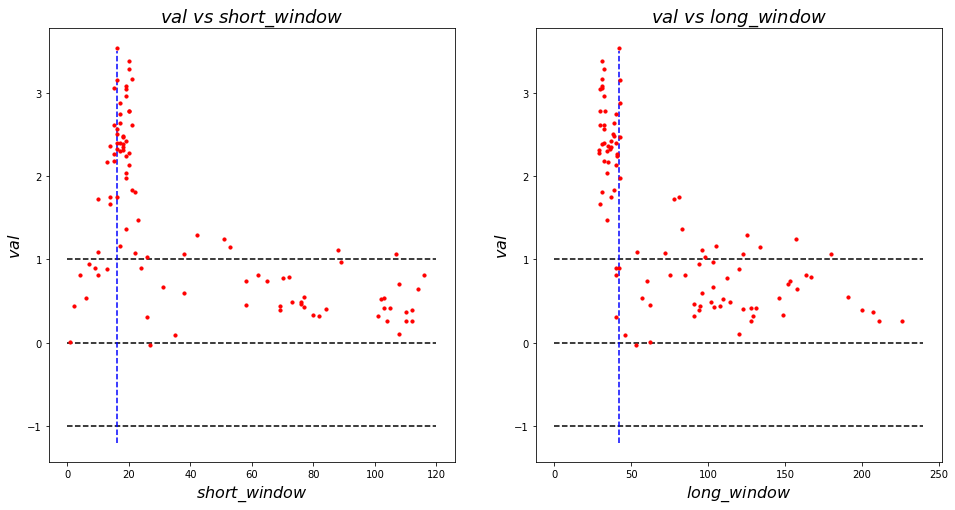

In [19]:
f, ax = plt.subplots(1,2, figsize = (16, 8))
ax[0].scatter(BO.X[:,0].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[0].set_title('$val$ $vs$ $short\_window$ ', fontsize=18)
ax[0].set_xlabel('$short\_window$', fontsize=16)
ax[0].set_ylabel('$val$', fontsize=16)
ax[0].hlines(0, 0, 120, color='black',linestyle="--")
ax[0].hlines(-1, 0, 120, color='black',linestyle="--")
ax[0].hlines(1, 0, 120, color='black',linestyle="--")
ax[0].vlines(BO.res['max']['max_params']['short_window'], -1.2, 3.5, color='blue',linestyle="--")

ax[1].scatter(BO.X[:,1].flatten() + BO.X[:,0].flatten(), BO.Y, c="red", s=10, zorder=10)
ax[1].set_title('$val$ $vs$ $long\_window$ ', fontsize=18)
ax[1].set_xlabel('$long\_window$', fontsize=16)
ax[1].set_ylabel('$val$', fontsize=16)
ax[1].hlines(0, 0, 240,color='black',linestyle="--")
ax[1].hlines(-1, 0, 240, color='black',linestyle="--")
ax[1].hlines(1, 0, 240,color='black',linestyle="--")
ax[1].vlines(BO.res['max']['max_params']['delta_window'] + BO.res['max']['max_params']['short_window'],
             -1.2, 3.5, color='blue',linestyle="--")

## Acquisition Function "Probability of Improvement"

* Prefer exploitation (xi=1e-4)
* Prefer exploration (xi=0.1)